In [1]:
import numpy as np
import matplotlib.pyplot as plt


class SingleLayer:
    def __init__(self, lr=.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses=[]
        self.w_history = []
        self.lr = lr
        self.l1 = l1
        self.l2 = l2
        
    def forward(self, x):
        return np.dot(x, self.w) + self.b
    
    def backward(self, x, err):
#         return x*err, err
        m = len(x)
        w_grad = np.dot(x.T, err) / m
        b_grad = np.sum(err) / m
        return w_grad, b_grad
    

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        m=len(x)
        self.w = np.random.rand(x.shape[1],1)
        self.b = np.random.rand()
        self.w_history.append(self.w.copy())
        for i in range(epochs):
            z = self.forward(x)
            a = self.activation(z)
            err = -(y-a)
            w_grad, b_grad = self.backward(x, err)
            w_grad += (self.l1*np.sign(self.w) + self.l2*self.w) / m
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            self.w_history.append(self.w.copy())
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.update_val_losses(x_val, y_val)
            
            
    def activation(self, z):
        return 1 / (1+np.exp(-z))
    
    def predict(self, x):
        return self.forward(x) > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x)==y.reshape(-1, 1))
    
    def update_val_losses(self, x_val, y_val):
        if x_val is None or y_val is None:
            return
        z = self.forward(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss())/ len(y_val))
        
    def reg_loss(self):
        return self.l1*np.sum(np.abs(self.w)) + self.l2/2*np.sum(self.w**2)

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                           test_size=.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                 stratify=y_train_all, test_size=.2, random_state=42)

In [3]:
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [5]:
single_layer = SingleLayer(l2=.01)
single_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=10000)

In [6]:
single_layer.score(x_val_scaled, y_val)

0.978021978021978

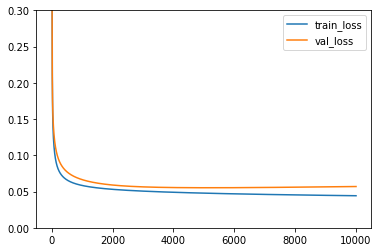

In [7]:
%matplotlib inline
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.legend(['train_loss','val_loss'])
plt.ylim(0, .3)
plt.show()

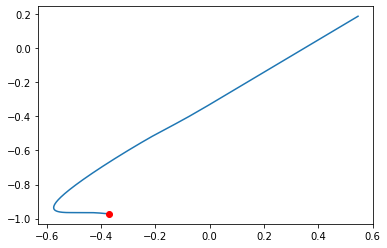

In [8]:
w2 = []; w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])

plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.show()

In [ ]:
class DualLayer(SingleLayer):
    def __init__(self, units=10, lr=.1, l1=0, l2=0):
        